# Градиентный спуск

В этом домашнем задании вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек.  

In [1]:
import abc

import matplotlib.pyplot as plt
import numpy as np

## Часть 1. Градиентный спуск (5 баллов)

Для обучения линейной регрессии необходим функционал ошибки, определим интерфейс для последующих реализаций.

In [2]:
class BaseLoss(abc.ABC):
    """Base class for losses"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """Calculate loss value based on inputs and weights

        Args:
            X: array with dataset objects, (n_samples, n_features)
            y: array with ground truth values, (n_samples,)
            w: linear regression weights, (n_features,)

        Returns:
            number, loss value
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """Calculate gradient vector based on inputs and weights

        Args:
            X: array with dataset objects, (n_samples, n_features)
            y: array with ground truth values, (n_samples,)
            w: linear regression weights, (n_features,)

        Returns:
            gradients for weights, (n_features,)
        """
        raise NotImplementedError

Вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

In [3]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        return np.mean((X @ w - y)**2)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        return 2 / len(y) * X.T @ (X @ w - y)

In [4]:
# Проведем небольшую проверку реализации

# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

In [5]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> np.ndarray:
    """Weights optimization with gradient descent

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    w_current = w_init.copy()
    w_history = [] 
    
    for _ in range(n_iterations):
        grad = loss.calc_grad(X, y, w_current)
        w_current -= lr * grad
        w_history.append(w_current.copy()) 
    
    return np.array(w_history)

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [6]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [7]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

155.26258214351958
0.8670644395649493


In [8]:
def plot_gd(w_list: np.ndarray, X: np.ndarray, y: np.ndarray, loss: BaseLoss):
    """Plot gradient descent trajectory

    Args:
        w_list: weights history, (n_iterations, n_features)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
    """
    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    plt.figure(figsize=(15, 6))
    plt.title("GD trajectory")
    plt.xlabel(r"$w_1$")
    plt.ylabel(r"$w_2$")
    plt.xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    plt.ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    plt.gca().set_aspect("equal")

    # visualize the level set
    CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
    CB = plt.colorbar(CS, shrink=0.8, extend="both")

    # visualize trajectory
    plt.scatter(w_list[:, 0], w_list[:, 1])
    plt.plot(w_list[:, 0], w_list[:, 1])

    plt.show()

При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`. Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

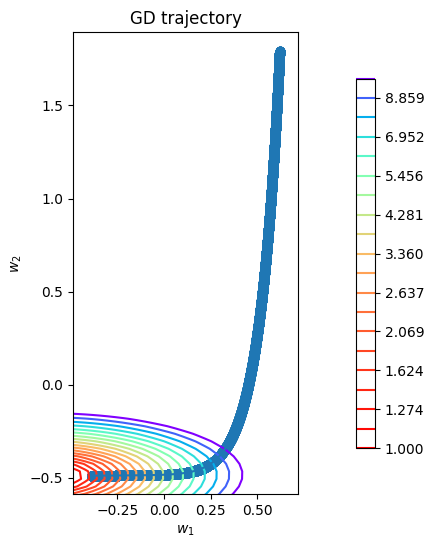

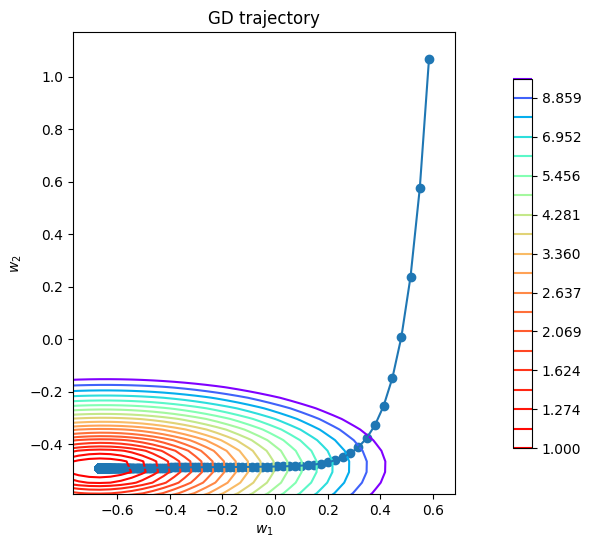

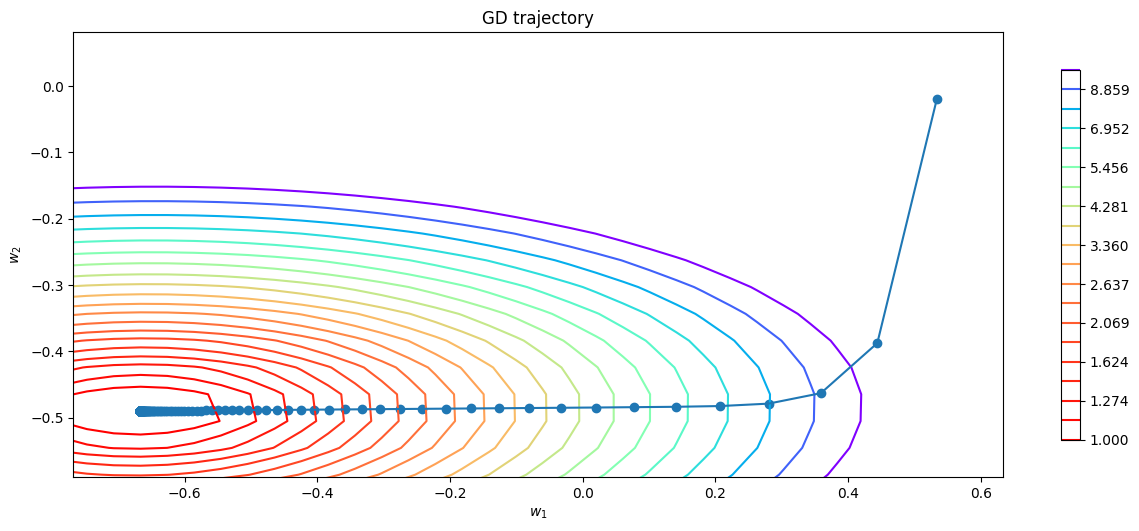

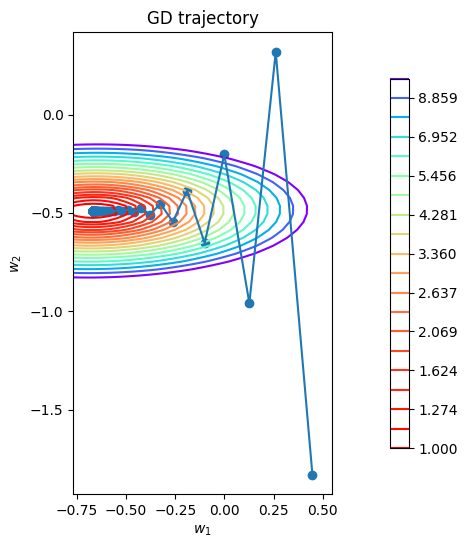

In [9]:
lr_values = [0.000001, 0.002, 0.005, 0.01]
for lr in lr_values:
    w_list = gradient_descent(w_init, X, y, loss, lr)
    plot_gd(w_list, X, y, loss)

Вывод: learning rate определяет скорость обучения и влияет на стабильность процесса. Слишком малый lr обеспечивает очень медленную сходимость и повышает риск попадания в локальный минимум. Слишком большой lr сильно меняет веса, повышая риск расходимости из-за перешагивания через минимум.

Теперь реализуем стохастический градиентный спуск. Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча.

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [10]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> np.ndarray:
    """Weights optimization with stochastic gradient descent

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        batch_size: number of samples in each batch, int
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    w_current = w_init.copy()
    w_history = [] 
    
    for _ in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        grad = loss.calc_grad(X[batch_indices], y[batch_indices], w_current)
        w_current -= lr * grad
        w_history.append(w_current.copy()) 
    
    return np.array(w_history)

При помощи функций `stochastic_gradient_descent` и `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`.

Сделайте и опишите свои выводы о том, как параметры `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

Batch_size: 10
lr: 1e-06


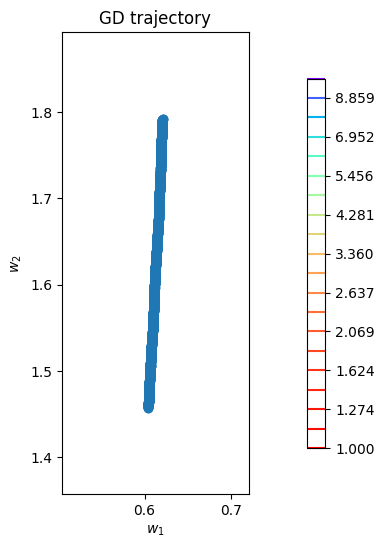

lr: 0.002


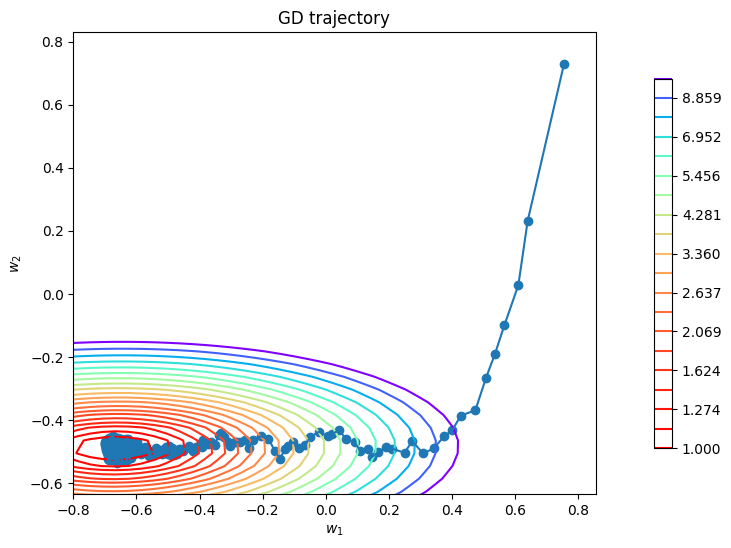

lr: 0.005


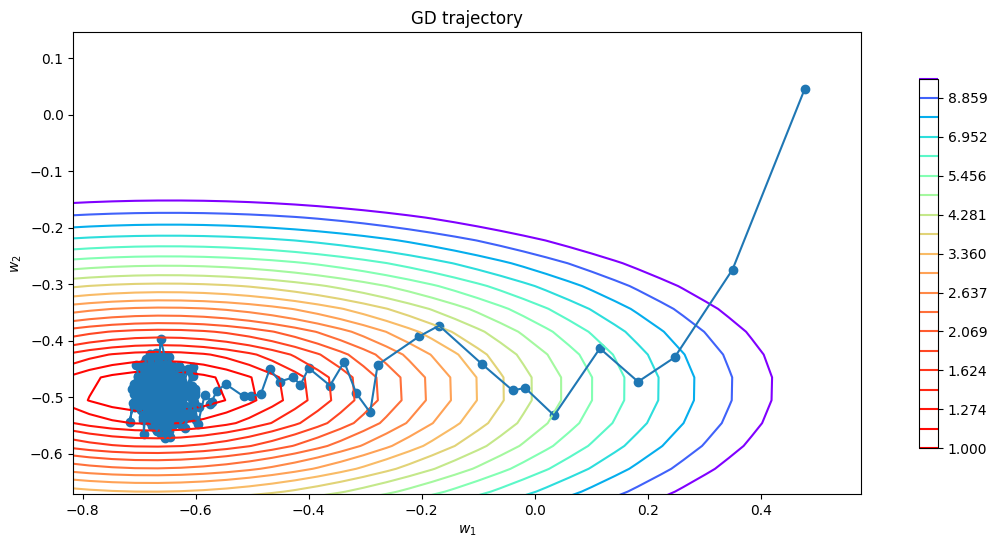

lr: 0.01


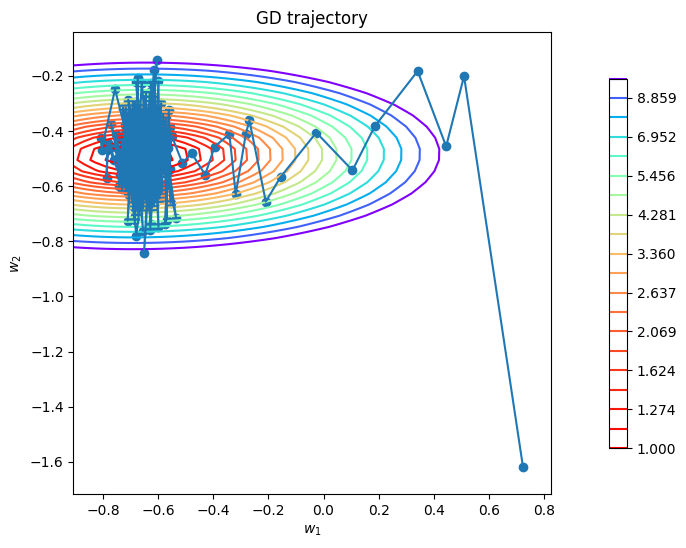

Batch_size: 50
lr: 1e-06


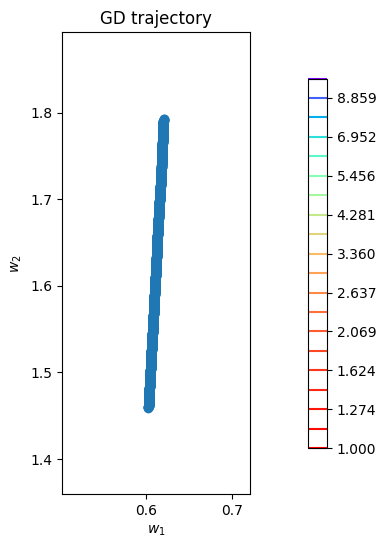

lr: 0.002


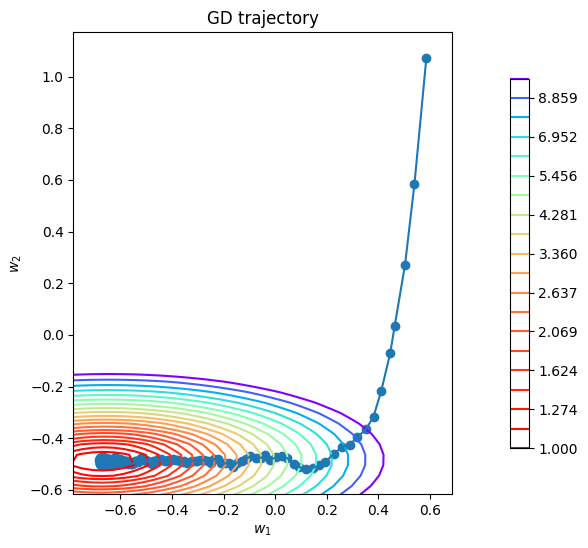

lr: 0.005


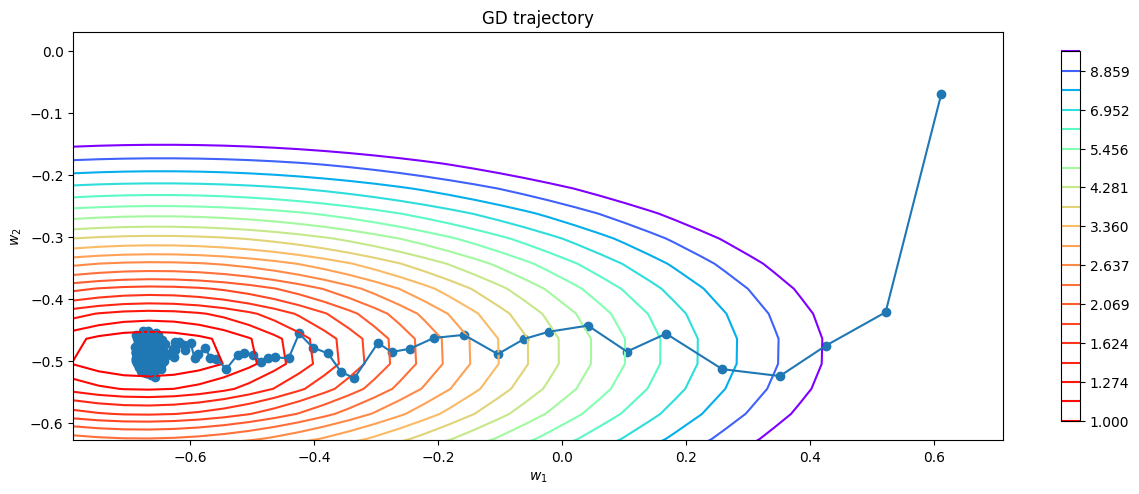

lr: 0.01


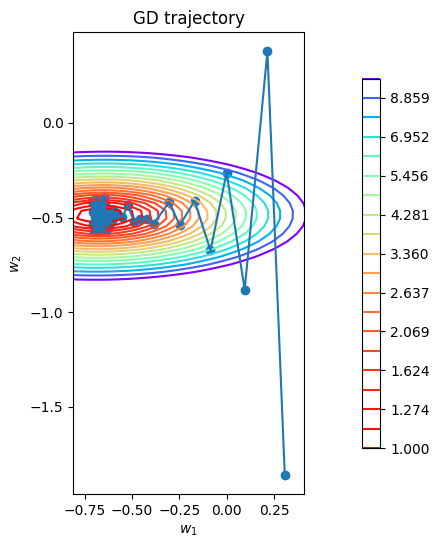

Batch_size: 100
lr: 1e-06


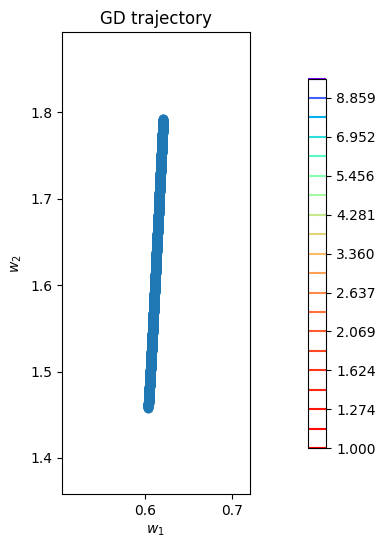

lr: 0.002


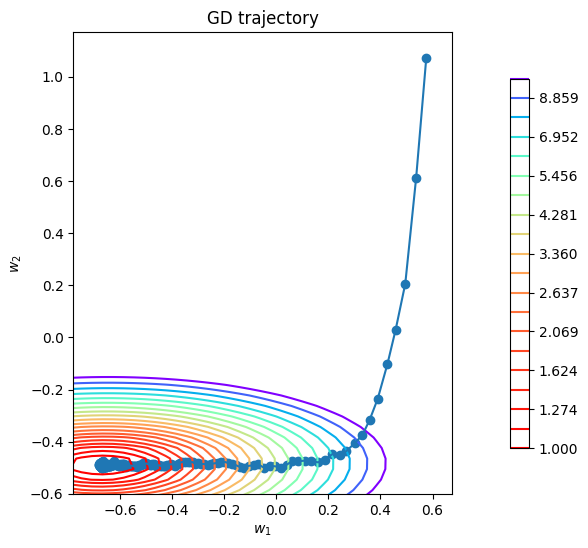

lr: 0.005


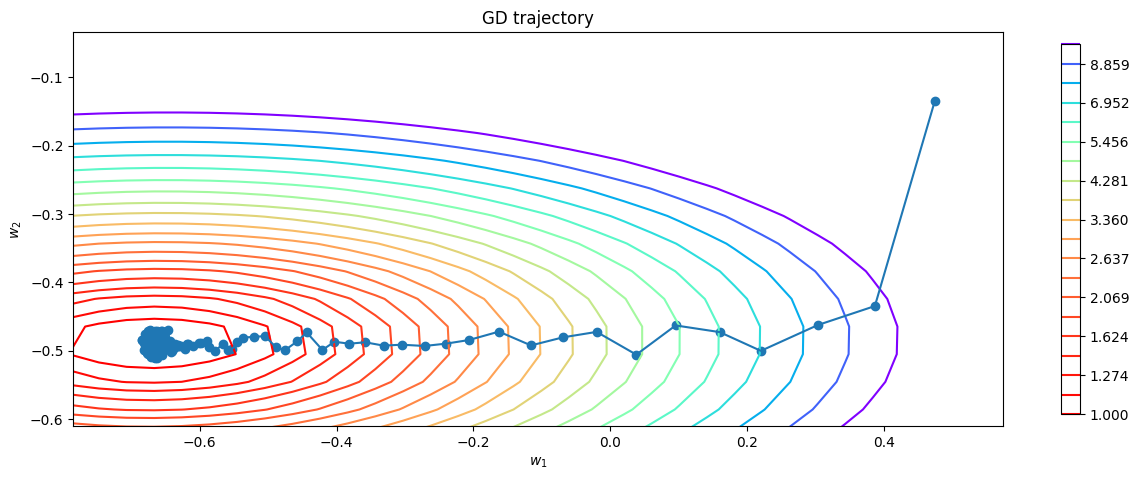

lr: 0.01


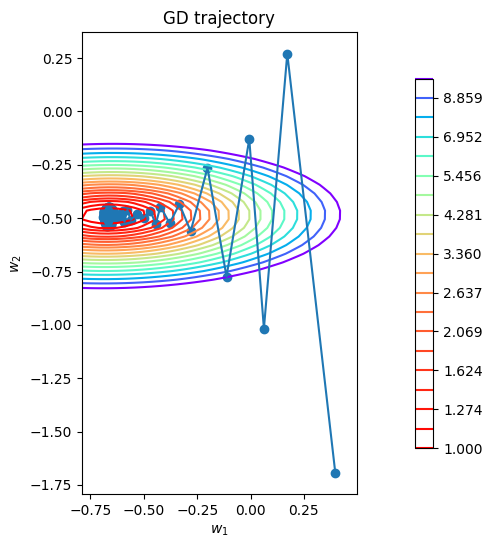

Batch_size: 200
lr: 1e-06


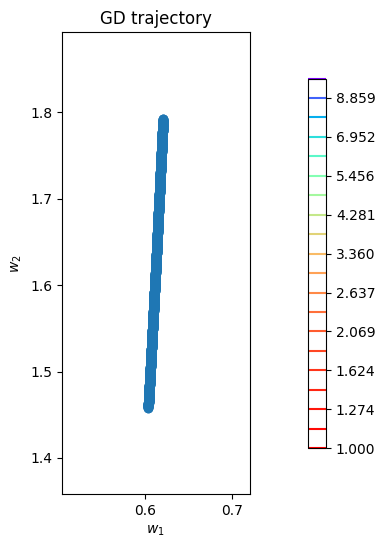

lr: 0.002


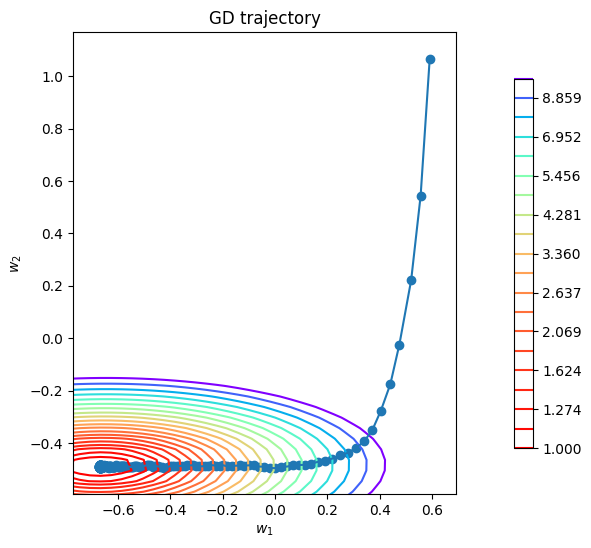

lr: 0.005


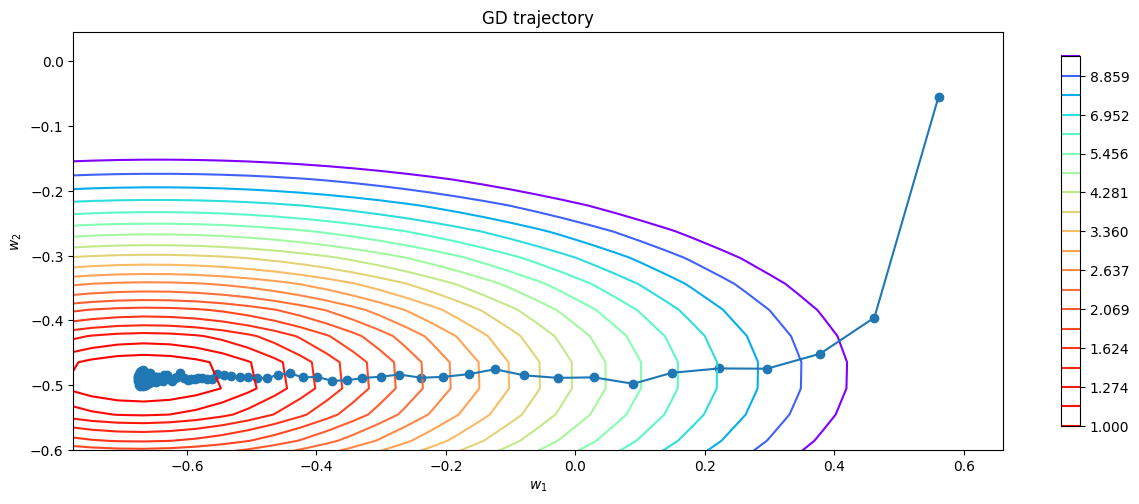

lr: 0.01


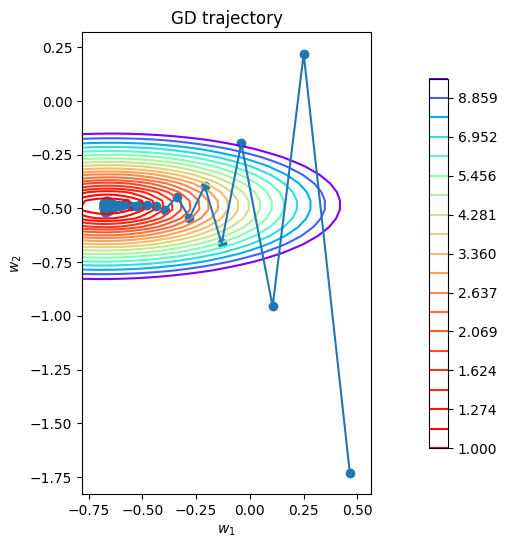

Batch_size: 300
lr: 1e-06


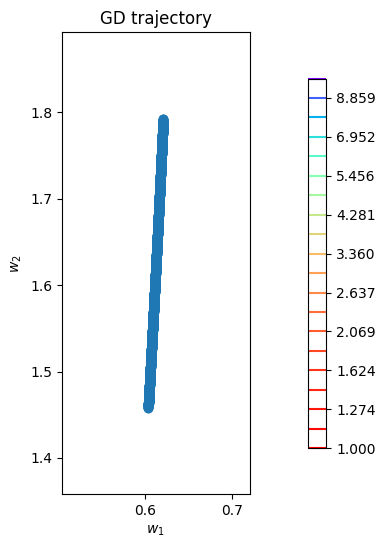

lr: 0.002


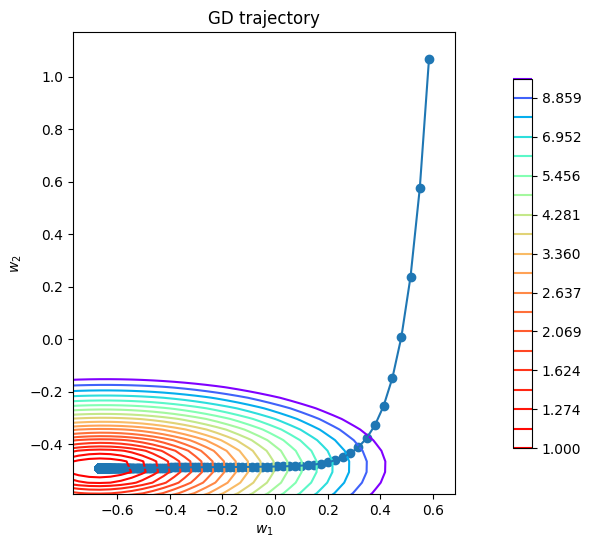

lr: 0.005


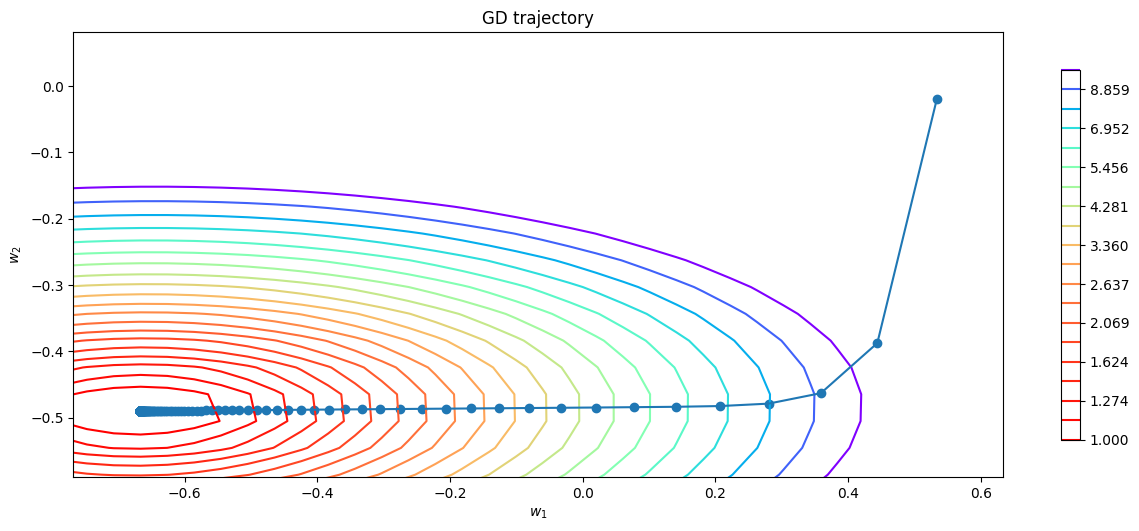

lr: 0.01


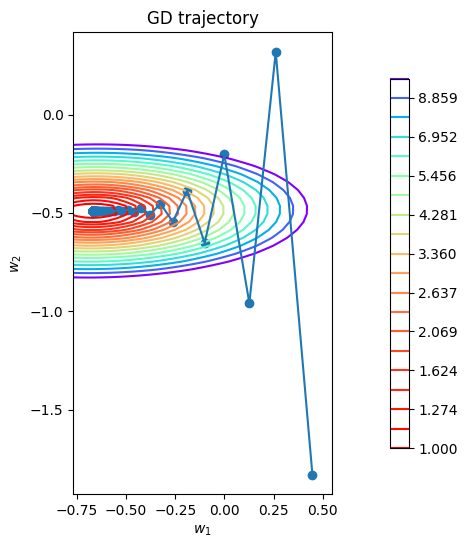

In [11]:
lr_values = [0.000001, 0.002, 0.005, 0.01]
batch_sizes = [10, 50, 100, 200, 300]
for batch_size in batch_sizes:
    print("Batch_size:", batch_size)
    for lr in lr_values:
        print("lr:", lr)
        w_list = stochastic_gradient_descent(w_init, X, y, loss, lr, batch_size)
        plot_gd(w_list, X, y, loss)

Вывод: lr влияет на стохастический градиент так же как и на обычный. Чем меньше значения batch_size, тем больший разброс шагов и меньше устойчивость к шумам, но так же и выше скорость работы.

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага.

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его.

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

Реализуйте SGD на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [12]:
def stochastic_gradient_descent_with_decay(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> np.ndarray:
    """Weights optimization with SGD and learning rate decay

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        batch_size: number of samples in each batch, int
        p: learning rate decay factor, float
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    w_current = w_init.copy()
    w_history = []
    s0 = 1 
    
    for t in range(n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        grad = loss.calc_grad(X[batch_indices], y[batch_indices], w_current)
        n_t = (s0 / (s0 + t)) ** p
        w_current -= lr * n_t * grad
        w_history.append(w_current.copy()) 
    
    return np.array(w_history)

При помощи новой функции `stochastic_gradient_descent_with_decay` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

p: 0.01


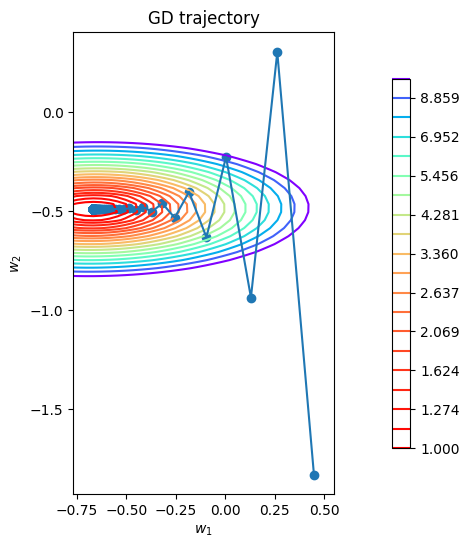

p: 0.1


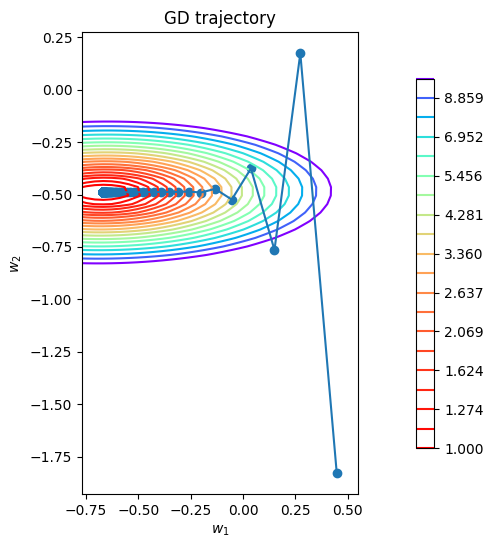

p: 1


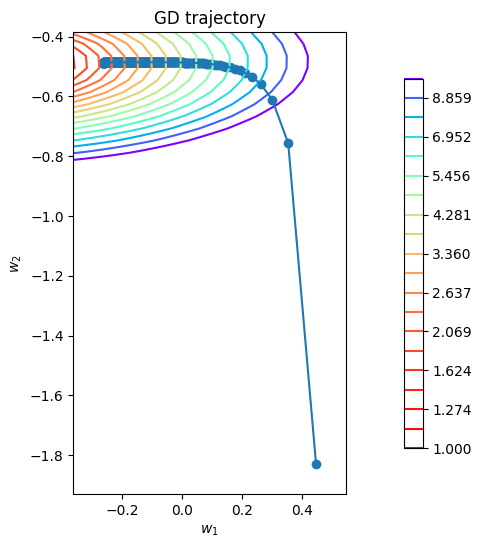

p: 10


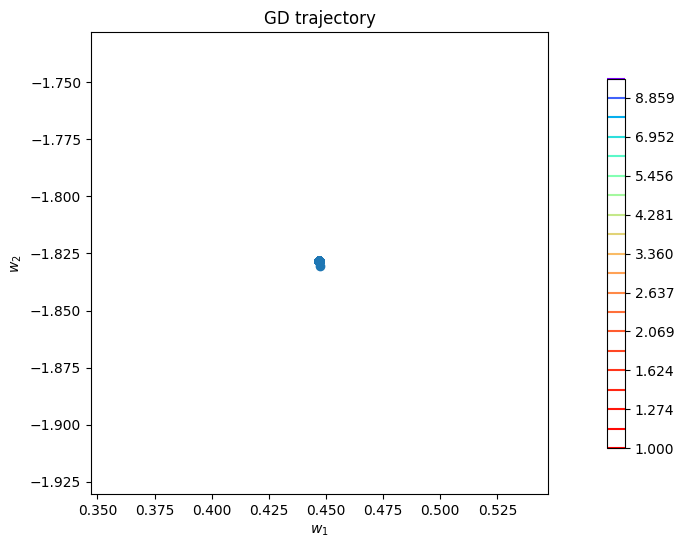

In [13]:
lr = 0.01
batch_sizes = 10
p_values = [0.01, 0.1, 1, 10]
for p in p_values:
    print("p:", p)
    w_list = stochastic_gradient_descent_with_decay(w_init, X, y, loss, lr, batch_size, p)
    plot_gd(w_list, X, y, loss)

Вывод:  p влияет на размер шага, уменьшая их с каждой итерацией. Чем ближе к минимуму, тем меньше будут шаги

Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

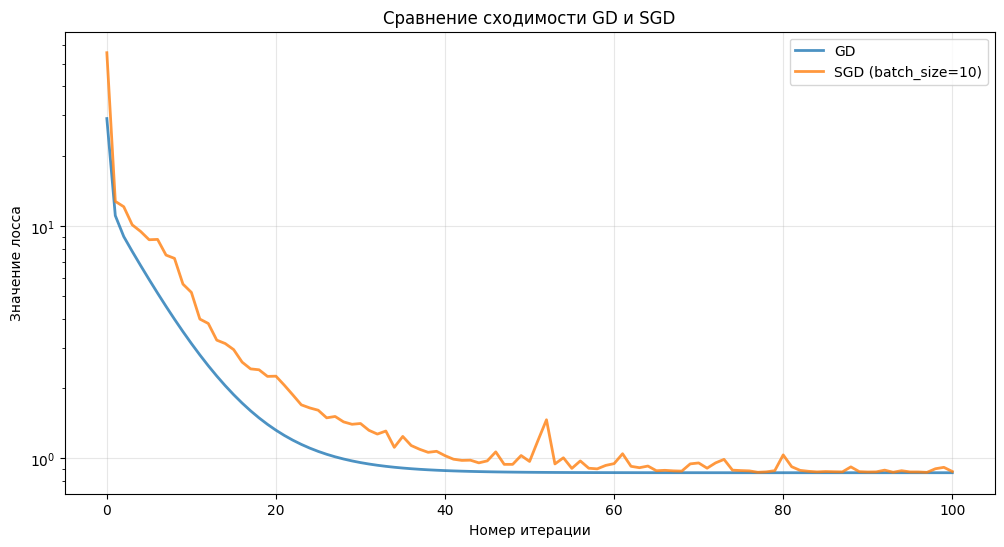

In [14]:
batch_size = 10
lr = 0.005
p = 0.1
iter_count = 101

w_history_gd = gradient_descent(w_init, X, y, loss, lr, iter_count)
loss_history_gd = [loss.calc_loss(X, y, w) for w in w_history_gd]


w_history_sgd = stochastic_gradient_descent_with_decay(
    w_init, X, y, loss, lr, batch_size, p, iter_count
)
loss_history_sgd = [loss.calc_loss(X, y, w) for w in w_history_sgd]


plt.figure(figsize=(12, 6))
plt.plot(loss_history_gd, label='GD', linewidth=2, alpha=0.8)
plt.plot(loss_history_sgd, label=f'SGD (batch_size={batch_size})', linewidth=2, alpha=0.8)

plt.xlabel('Номер итерации')
plt.ylabel('Значение лосса')
plt.title('Сравнение сходимости GD и SGD')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log') 
plt.show()

SGD получился более шумным, но на сотой итерации получил то же значение loss, что и GD, но при этом за счет batch_size=10 работал быстрее.

## Часть 2. Линейная регрессия (5 баллов)

Напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`. Не забывайте про единичный признак!

В методе `predict` мы будем применять нашу регрессию к датасету,

In [15]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)
        X_with_bias = np.column_stack([np.ones(X.shape[0]), X])
        w_init = np.zeros(X_with_bias.shape[1])
        w_history = gradient_descent(w_init, X_with_bias, y, self.loss, self.lr)
        self.w = w_history[-1]
        
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        X = np.asarray(X)
        X_with_bias = np.column_stack([np.ones(X.shape[0]), X])
        return X_with_bias @ self.w

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации.

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [16]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [17]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw.head()
X_raw = X_raw[~X_raw[25].isna()].reset_index()

In [18]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [19]:
X_raw

,index,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,24
0,0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
1,1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
2,2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,...,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26
3,3,2,164.0,audi,gas,std,four,sedan,fwd,front,...,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30
4,4,2,164.0,audi,gas,std,four,sedan,4wd,front,...,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,200,-1,95.0,volvo,gas,std,four,sedan,rwd,front,...,four,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28
197,201,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,...,four,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25
198,202,-1,95.0,volvo,gas,std,four,sedan,rwd,front,...,six,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23
199,203,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,...,six,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27


In [20]:
X_raw = X_raw.drop(columns=["index"])

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

numeric_features = X_raw.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_raw.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())                 
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_processed = preprocessor.fit_transform(X_raw)

In [22]:

X = X_processed 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=19, shuffle=True
)

Обучите линейную регрессию на обучающей выборке

In [23]:

linear_regression.fit(X_train, y_train)

Для оценки качества реализуем `r2_score`, который является нормализацией `mean_square_error`.

In [24]:
def r2_score(y_true: np.ndarray, y_predicted: np.ndarray) -> float:
    return 1 - np.sum((y_true - y_predicted) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке.

In [25]:
print("r2_score train =", r2_score(y_train, linear_regression.predict(X_train)))
print("r2_score test =", r2_score(y_test, linear_regression.predict(X_test)))

r2_score train = 0.9692383181464499
r2_score test = 0.9387555623324161


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

Обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак).

**Вопрос**: надо ли регуляризовывать bias?

**Ответ**: $\textit{Нет. bias не подвержен переобучению, так как не зависит от параметров объектов.}$

Не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [26]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        mse_loss = np.mean((X @ w - y) ** 2)
        weights_without_bias = w[:-1] 
        regularization = self.coef * np.sum(weights_without_bias ** 2)
        return mse_loss + regularization

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        errors = X @ w - y
        mse_grad = (2 / y.size) * X.T @ errors
        reg_grad = 2 * self.coef * w
        reg_grad[-1] = 0  
        return mse_grad + reg_grad

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [27]:
linear_regression = LinearRegression(MSEL2Loss(0.1))

Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации.

In [28]:
results = []

models = {
    'Без регуляризации': LinearRegression(MSELoss(), lr=0.01),
    'L2 coef=0.0001': LinearRegression(MSEL2Loss(coef=0.0001), lr=0.01),
    'L2 coef=0.001': LinearRegression(MSEL2Loss(coef=0.001), lr=0.01),
    'L2 coef=0.01': LinearRegression(MSEL2Loss(coef=0.01), lr=0.01)
}


for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_mse = np.mean((y_train - y_pred_train) ** 2)
    test_mse = np.mean((y_test - y_pred_test) ** 2)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results.append({
        'Модель': name,
        'Train MSE': train_mse, 
        'Test MSE': test_mse,
        'Train R2': train_r2,
        'Test R2': test_r2,
        'Разница MSE': train_mse - test_mse,
        'Разница R2': train_r2 - test_r2
    })

In [29]:
results_df = pd.DataFrame(results)

print("Сравнение моделей линейной регрессии:")


for _, row in results_df.iterrows():
    print(f"\nМодель: {row['Модель']}")
    print(f"  Train MSE: {row['Train MSE']:.6f}")
    print(f"  Test MSE:  {row['Test MSE']:.6f}")
    print(f"  Train R2:  {row['Train R2']:.6f}")
    print(f"  Test R2:   {row['Test R2']:.6f}")
    print(f"  Разница train-test MSE: {row['Разница MSE']:.6f}")
    print(f"  Разница train-test R2: {row['Разница R2']:.6f}")




Сравнение моделей линейной регрессии:

Модель: Без регуляризации
  Train MSE: 1986097.026299
  Test MSE:  3356628.757225
  Train R2:  0.969108
  Test R2:   0.940511
  Разница train-test MSE: -1370531.730926
  Разница train-test R2: 0.028597

Модель: L2 coef=0.0001
  Train MSE: 1990287.585126
  Test MSE:  3311112.872981
  Train R2:  0.969043
  Test R2:   0.941318
  Разница train-test MSE: -1320825.287856
  Разница train-test R2: 0.027725

Модель: L2 coef=0.001
  Train MSE: 2068588.188379
  Test MSE:  3142822.100598
  Train R2:  0.967825
  Test R2:   0.944300
  Разница train-test MSE: -1074233.912219
  Разница train-test R2: 0.023525

Модель: L2 coef=0.01
  Train MSE: 2964998.667064
  Test MSE:  4173816.917213
  Train R2:  0.953882
  Test R2:   0.926028
  Разница train-test MSE: -1208818.250150
  Разница train-test R2: 0.027854


In [30]:
best_model = results_df.loc[results_df['Test MSE'].idxmin()]
print(f"\nЛучшая модель: {best_model['Модель']}")
print(f"   Test MSE: {best_model['Test MSE']:.6f}")
print(f"   Test R2:  {best_model['Test R2']:.6f}")

base_model = results_df[results_df['Модель'] == 'Без регуляризации'].iloc[0]
print(f"\nСравнение с базовой моделью:")
print(f"   Улучшение Test MSE: {(best_model['Test MSE'] - base_model['Test MSE']):.6f}")
print(f"   Улучшение Test R2:  {(best_model['Test R2'] - base_model['Test R2']):.6f}")


Лучшая модель: L2 coef=0.001
   Test MSE: 3142822.100598
   Test R2:  0.944300

Сравнение с базовой моделью:
   Улучшение Test MSE: -213806.656627
   Улучшение Test R2:  0.003789


В нашем датасете могут быть выбросы, с ними хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

In [31]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        z = X @ w - y  
        phi_z = np.where(
            np.abs(z) < self.eps,
            0.5 * z ** 2,  
            self.eps * (np.abs(z) - 0.5 * self.eps) 
        )
        
        return np.mean(phi_z)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        z = X @ w - y  
        grad_phi = np.where(
            np.abs(z) < self.eps,
            z,  
            self.eps * np.sign(z)  
        )
        
        return X.T @ grad_phi / len(y)

Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [32]:
results = []

models = {
    'MSE Loss': LinearRegression(MSELoss(), lr=0.01),
    'Huber eps=100': LinearRegression(HuberLoss(eps=100), lr=0.01),
    'Huber eps=1000': LinearRegression(HuberLoss(eps=1000), lr=0.01),
    'Huber eps=10000': LinearRegression(HuberLoss(eps=10000), lr=0.01),
    'Huber eps=50000': LinearRegression(HuberLoss(eps=50000), lr=0.01)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_mse = np.mean((y_train - y_pred_train) ** 2)
    test_mse = np.mean((y_test - y_pred_test) ** 2)
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    
    results.append({
        'Модель': name,
        'Train MSE': train_mse, 
        'Test MSE': test_mse,
        'Train R2': train_r2,
        'Test R2': test_r2,
        'Разница MSE': train_mse - test_mse,
        'Разница R2': train_r2 - test_r2
    })

In [33]:
results_df = pd.DataFrame(results)

print("Сравнение моделей линейной регрессии:")


for _, row in results_df.iterrows():
    print(f"\nМодель: {row['Модель']}")
    print(f"  Train MSE: {row['Train MSE']:.6f}")
    print(f"  Test MSE:  {row['Test MSE']:.6f}")
    print(f"  Train R2:  {row['Train R2']:.6f}")
    print(f"  Test R2:   {row['Test R2']:.6f}")
    print(f"  Разница train-test MSE: {row['Разница MSE']:.6f}")
    print(f"  Разница train-test R2: {row['Разница R2']:.6f}")

Сравнение моделей линейной регрессии:

Модель: MSE Loss
  Train MSE: 1986097.026299
  Test MSE:  3356628.757225
  Train R2:  0.969108
  Test R2:   0.940511
  Разница train-test MSE: -1370531.730926
  Разница train-test R2: 0.028597

Модель: Huber eps=100
  Train MSE: 5141127.899849
  Test MSE:  9060275.878234
  Train R2:  0.920035
  Test R2:   0.839426
  Разница train-test MSE: -3919147.978385
  Разница train-test R2: 0.080609

Модель: Huber eps=1000
  Train MSE: 2712895.646415
  Test MSE:  3965752.580920
  Train R2:  0.957803
  Test R2:   0.929715
  Разница train-test MSE: -1252856.934505
  Разница train-test R2: 0.028088

Модель: Huber eps=10000
  Train MSE: 2009142.890567
  Test MSE:  3277547.921496
  Train R2:  0.968750
  Test R2:   0.941912
  Разница train-test MSE: -1268405.030929
  Разница train-test R2: 0.026837

Модель: Huber eps=50000
  Train MSE: 2009085.372691
  Test MSE:  3277866.933969
  Train R2:  0.968751
  Test R2:   0.941907
  Разница train-test MSE: -1268781.561278
 

In [34]:
best_model = results_df.loc[results_df['Test MSE'].idxmin()]
print(f"\nЛучшая модель: {best_model['Модель']}")
print(f"   Test MSE: {best_model['Test MSE']:.6f}")
print(f"   Test R2:  {best_model['Test R2']:.6f}")

base_model = results_df[results_df['Модель'] == 'MSE Loss'].iloc[0]
print(f"\nСравнение с базовой моделью:")
print(f"   Улучшение Test MSE: {(best_model['Test MSE'] - base_model['Test MSE']):.6f}")
print(f"   Улучшение Test R2:  {(best_model['Test R2'] - base_model['Test R2']):.6f}")


Лучшая модель: Huber eps=10000
   Test MSE: 3277547.921496
   Test R2:  0.941912

Сравнение с базовой моделью:
   Улучшение Test MSE: -79080.835729
   Улучшение Test R2:  0.001402
